NEURAL COMMUNICATION SYSTEM - BER ANALYSIS
Configuration: M=16, N=4
Training for different SNR values...

AWGN Channel:


AWGN Training: 100%|██████████| 10/10 [04:32<00:00, 27.26s/it]



Rayleigh Channel:


Rayleigh Training: 100%|██████████| 10/10 [04:45<00:00, 28.55s/it]


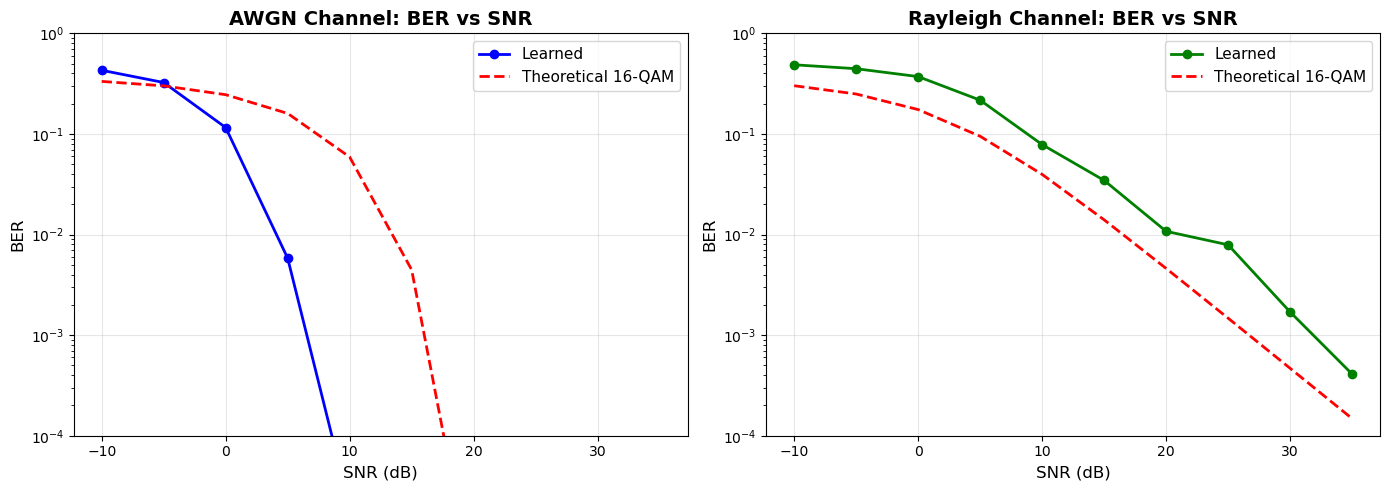


Generating constellation plots for SNR = 20 dB...
Training AWGN model for constellation...
Training Rayleigh model for constellation...


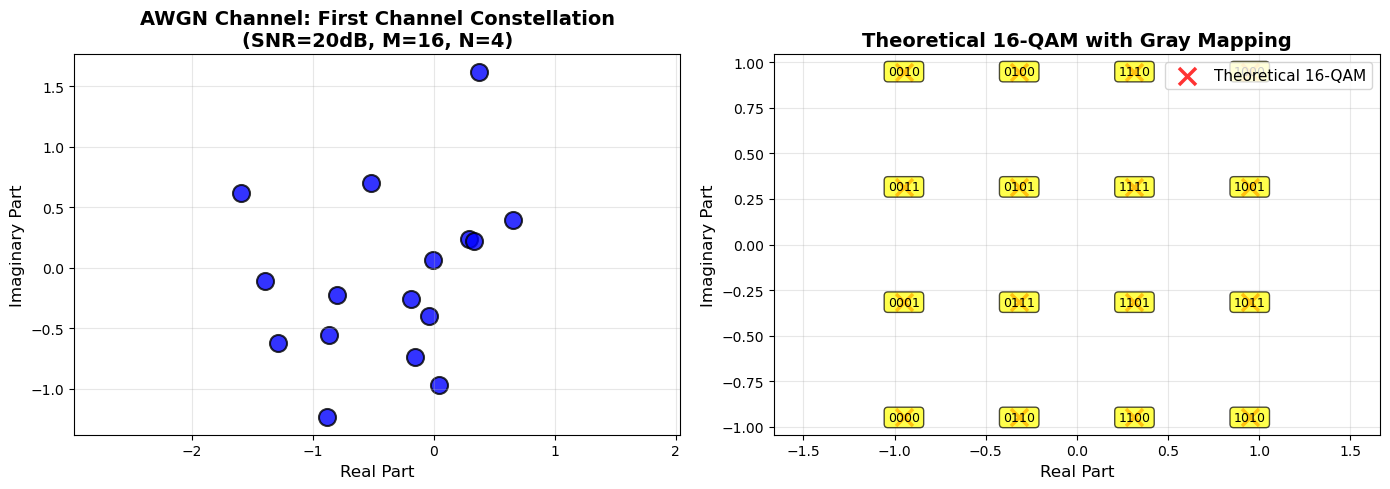

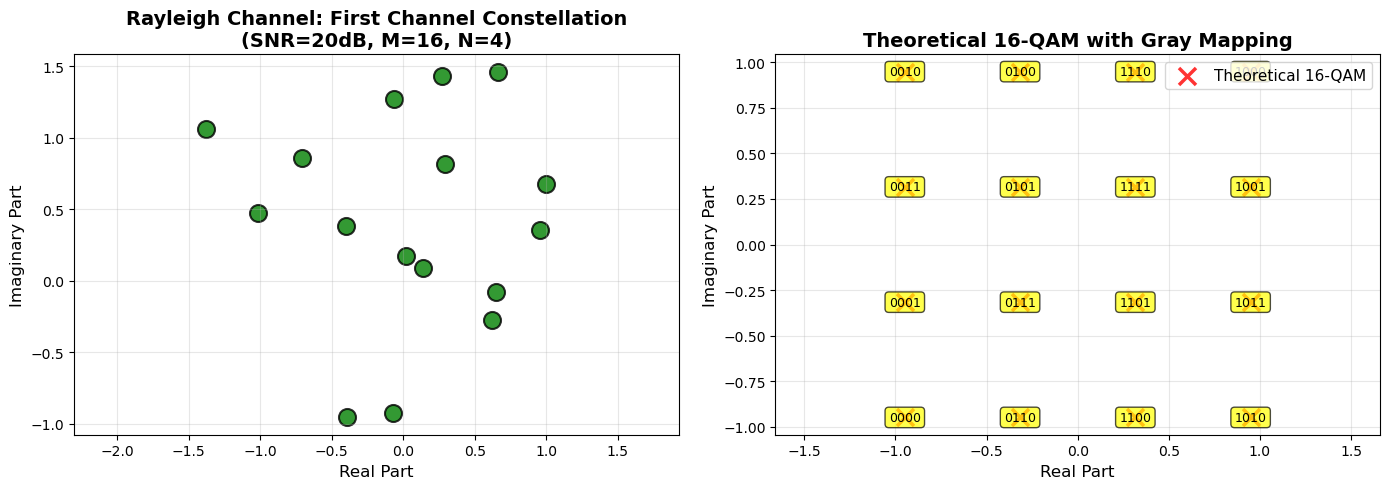


BER Results Summary
SNR (dB) |     AWGN BER |   Theoretical AWGN |   Rayleigh BER |   Theoretical Rayleigh
--------------------------------------------------------------------------------
   -10.0 |   4.2927e-01 |         3.3283e-01 |     4.8682e-01 |             3.0146e-01
    15.0 |   0.0000e+00 |         4.4654e-03 |     3.4512e-02 |             1.3998e-02


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

# ====================
# 1. Set seeds 
# ====================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ====================
# 2. helper functions
# ====================

def complex_to_real(x):
    """Convert complex tensor to real (stacking real and imag parts)"""
    return torch.view_as_real(x).reshape(*x.shape[:-1], -1)

def real_to_complex(x): 
    """Convert real tensor to complex"""
    return torch.view_as_complex(x.reshape(*x.shape[:-1], -1, 2).contiguous())

def normalize_power(x):
    """Normalize to unit average power per symbol"""
    power = torch.mean(torch.abs(x) ** 2, dim=1, keepdim=True)
    return x / torch.sqrt(power + 1e-8)

def awgn_channel(x, snr_db):
    """AWGN channel"""
    snr_linear = 10 ** (snr_db / 10)
    noise_power = 1.0 / snr_linear
    noise_std = np.sqrt(noise_power / 2)
    
    noise_real = torch.randn_like(x.real) * noise_std
    noise_imag = torch.randn_like(x.imag) * noise_std
    noise = torch.complex(noise_real, noise_imag)
    
    return x + noise

def rayleigh_channel(x, snr_db):
    """
    Rayleigh Block-Fading channel as per paper.
    Each batch element gets ONE channel realization that applies to all N symbols.
    """
    batch_size = x.shape[0]
    snr_linear = 10 ** (snr_db / 10)
    noise_power = 1.0 / snr_linear
    
    # Generate ONE channel coefficient per batch element (not per symbol!)
    # h ~ CN(0, 1), meaning E[|h|²] = 1
    h_real = torch.randn(batch_size, 1, device=x.device, dtype=x.real.dtype) / np.sqrt(2)
    h_imag = torch.randn(batch_size, 1, device=x.device, dtype=x.imag.dtype) / np.sqrt(2)
    h = torch.complex(h_real, h_imag)  # Shape: (batch_size, 1)
    
    # Apply fading to all N symbols
    y = h * x  # Broadcasting over N symbols
    
    # Add noise
    noise_std = np.sqrt(noise_power / 2)
    noise_real = torch.randn_like(y.real) * noise_std
    noise_imag = torch.randn_like(y.imag) * noise_std
    noise = torch.complex(noise_real, noise_imag)
    
    return y + noise    

# ====================
# 3. Neural Networks 
# ====================

class Transmitter(nn.Module):
    def __init__(self, M=16, N=4):
        super().__init__()
        self.M = M
        self.N = N
        
        self.embedding = nn.Sequential(
            nn.Embedding(M, M),
            nn.ELU()
        )
        
        self.fc = nn.Linear(M, 2 * N)
        
    def forward(self, m):
        x = self.embedding(m)
        x = self.fc(x)
        x = real_to_complex(x)
        return normalize_power(x)

class ReceiverAWGN(nn.Module):
    """Simple receiver for AWGN channel"""
    def __init__(self, M=16, N=4, hidden_size=256):
        super().__init__()
        self.M = M
        self.N = N
        
        self.net = nn.Sequential(
            nn.Linear(2 * N, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, M)
        )
        
    def forward(self, y):
        x_real = complex_to_real(y)
        logits = self.net(x_real)
        return torch.softmax(logits, dim=1)

class ReceiverRayleigh(nn.Module):
    """
    Receiver for Rayleigh channel following paper architecture (Figure 4).
    """
    def __init__(self, M=16, N=4, hidden_size=256):
        super().__init__()
        self.M = M
        self.N = N
        
        # Channel estimation layers
        self.h_est_layer1 = nn.Linear(2 * N, hidden_size)
        self.h_est_layer2 = nn.Linear(hidden_size, 2)  # 2 real values = 1 complex h
        
        # Detection layers after equalization
        self.detect_layer1 = nn.Linear(2 * N, hidden_size)
        self.detect_layer2 = nn.Linear(hidden_size, M)
        
    def forward(self, y):
        batch_size = y.shape[0]
        
        # Convert to real
        y_real = complex_to_real(y)  # (batch_size, 2N)
        
        # Channel estimation
        h_features = torch.relu(self.h_est_layer1(y_real))
        h_est_real = self.h_est_layer2(h_features)  # (batch_size, 2)
        h_est = real_to_complex(h_est_real)  # (batch_size, 1)
        
        # Equalization: y/h_est
        y_eq = y / (h_est + 1e-8)
        
        # Convert equalized signal to real
        y_eq_real = complex_to_real(y_eq)  # (batch_size, 2N)
        
        # Detection network
        detect_features = torch.relu(self.detect_layer1(y_eq_real))
        logits = self.detect_layer2(detect_features)  # (batch_size, M)
        
        return torch.softmax(logits, dim=1)
    

# ====================
# 4. Training Functions 
# ====================

def train_receiver(transmitter, receiver, optimizer_R, channel_fn, snr_db, 
                   batch_size=256, seed_offset=0):
    """Train receiver with supervised learning"""
    transmitter.eval()
    receiver.train()
    
    device = next(transmitter.parameters()).device
    
    # Generate training messages
    torch.manual_seed(seed_offset + hash("receiver") % 10000)
    m = torch.randint(0, transmitter.M, (batch_size,)).to(device)
    
    # Transmit
    with torch.no_grad():
        x = transmitter(m)
        y = channel_fn(x, snr_db)
    
    # Receive and compute loss
    p = receiver(y)
    loss = nn.functional.cross_entropy(p, m)
    
    # Update receiver
    optimizer_R.zero_grad()
    loss.backward()
    optimizer_R.step()
    
    return loss.item()

def train_transmitter(transmitter, receiver, optimizer_T, channel_fn, snr_db,
                      sigma_pi_sq=0.02, batch_size=256, seed_offset=0):
    """Train transmitter with RL"""
    transmitter.train()
    receiver.eval()
    
    device = next(transmitter.parameters()).device
    
    # Generate training messages
    torch.manual_seed(seed_offset + hash("transmitter") % 10000)
    m = torch.randint(0, transmitter.M, (batch_size,)).to(device)
    
    # Get transmitter output
    x_det = transmitter(m)
    
    # Add exploration noise
    scale = np.sqrt(1 - sigma_pi_sq)
    noise_std = np.sqrt(sigma_pi_sq / 2)
    
    noise_real = torch.randn_like(x_det.real) * noise_std
    noise_imag = torch.randn_like(x_det.imag) * noise_std
    w = torch.complex(noise_real, noise_imag)
    
    x_p = scale * x_det + w
    
    # Send through channel and get losses
    with torch.no_grad():
        y = channel_fn(x_p, snr_db)
        p = receiver(y)
        losses = -torch.log(p[torch.arange(batch_size).to(device), m] + 1e-8)
    
    # Compute policy gradient
    mu = scale * x_det
    w_vec = x_p - mu
    
    # Convert to real for dot product computation
    w_real = complex_to_real(w_vec)  # (batch_size, 2N)
    x_det_real = complex_to_real(x_det)  # (batch_size, 2N)
    
    # Compute dot products
    dot_products = torch.sum(w_real * x_det_real, dim=1)  # (batch_size,)
    
    # Policy gradient with baseline
    scale_factor = 2 * scale / sigma_pi_sq
    
    # Surrogate loss
    surrogate_loss = scale_factor * torch.mean(losses.detach() * dot_products)
    
    # Update transmitter
    optimizer_T.zero_grad()
    surrogate_loss.backward()
    optimizer_T.step()
    
    return torch.mean(losses).item()



# ====================
# 5. BER Evaluation Function
# ====================

def evaluate_ber(transmitter, receiver, channel_fn, snr_db, M, N, 
                 num_batches=50, batch_size=512, use_gray_mapping=True):
    """
    Evaluate Bit Error Rate (BER) only
    Returns: BER value (float)
    """
    device = next(transmitter.parameters()).device
    transmitter.eval()
    receiver.eval()
    
    total_bit_errors = 0
    total_bits = 0
    
    # Calculate number of bits per symbol
    bits_per_symbol = int(np.log2(M))
    
    # Create bit mapping (Gray coding by default)
    if use_gray_mapping:
        # Generate Gray code mapping
        def binary_to_gray(n, bits):
            """Convert binary to Gray code"""
            gray = n ^ (n >> 1)
            return [(gray >> i) & 1 for i in range(bits-1, -1, -1)]
        
        # Create mapping from symbol index to bit array
        symbol_to_bits = {}
        for symbol in range(M):
            symbol_to_bits[symbol] = binary_to_gray(symbol, bits_per_symbol)
    else:
        # Natural binary mapping
        symbol_to_bits = {}
        for symbol in range(M):
            symbol_to_bits[symbol] = [(symbol >> i) & 1 for i in range(bits_per_symbol-1, -1, -1)]
    
    with torch.no_grad():
        for i in range(num_batches):
            torch.manual_seed(123456 + i)
            
            # Generate test messages
            m_test = torch.randint(0, M, (batch_size,)).to(device)
            
            # Transmit and receive
            x_test = transmitter(m_test)
            y_test = channel_fn(x_test, snr_db)
            p_test = receiver(y_test)
            pred = torch.argmax(p_test, dim=1)
            
            # Convert to numpy for bit operations
            m_test_np = m_test.cpu().numpy()
            pred_np = pred.cpu().numpy()
            
            # Calculate bit errors
            for true_symbol, pred_symbol in zip(m_test_np, pred_np):
                true_bits = symbol_to_bits[true_symbol]
                pred_bits = symbol_to_bits[pred_symbol]
                
                # Count differing bits
                bit_errors = sum(tb != pb for tb, pb in zip(true_bits, pred_bits))
                total_bit_errors += bit_errors
                total_bits += bits_per_symbol
    
    # Calculate BER
    ber = total_bit_errors / total_bits if total_bits > 0 else 1.0
    
    return ber

def theoretical_ber_16qam_awgn(snr_db):
    """Theoretical BER for 16-QAM in AWGN channel"""
    snr_linear = 10 ** (snr_db / 10)
    # Exact BER for 16-QAM in AWGN with Gray coding
    return (3/8) * math.erfc(np.sqrt(snr_linear/10))

def theoretical_ber_16qam_rayleigh(snr_db):
    """Theoretical BER for 16-QAM in Rayleigh fading channel"""
    snr_linear = 10 ** (snr_db / 10)
    # Approximation for 16-QAM over Rayleigh with Gray coding
    return 0.375 * (1 - np.sqrt(0.8 * snr_linear / (2 + 0.8 * snr_linear)))


# ====================
# 6. Training Function for Single SNR
# ====================

def train_for_snr(snr_db, channel_type='awgn', M=16, N=4, iterations=800):
    """
    Train system for a specific SNR and channel type
    Returns: transmitter, receiver, final BER
    """
    set_seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Select channel function
    if channel_type == 'rayleigh':
        channel_fn = rayleigh_channel
        receiver = ReceiverRayleigh(M, N, hidden_size=256).to(device)
    else:
        channel_fn = awgn_channel
        receiver = ReceiverAWGN(M, N, hidden_size=256).to(device)
    
    # Initialize models
    transmitter = Transmitter(M, N).to(device)
    
    # Optimizers
    optimizer_T = optim.Adam(transmitter.parameters(), lr=1e-3)
    optimizer_R = optim.Adam(receiver.parameters(), lr=1e-3)
    
    # Training
    for it in range(iterations):
        seed_offset = 42 + it * 1000
        
        # Train receiver
        for step in range(1):
            _ = train_receiver(transmitter, receiver, optimizer_R, 
                              channel_fn, snr_db, 
                              batch_size=256,
                              seed_offset=seed_offset + step)
        
        # Train transmitter
        for step in range(1):
            _ = train_transmitter(transmitter, receiver, optimizer_T,
                                 channel_fn, snr_db, sigma_pi_sq=0.02,
                                 batch_size=256,
                                 seed_offset=seed_offset + 100 + step)
    
    # Evaluate final BER
    final_ber = evaluate_ber(transmitter, receiver, channel_fn, snr_db, M, N)
    
    return transmitter, receiver, final_ber


# ====================
# 7. Plotting Functions
# ====================

def plot_ber_vs_snr():
    """
    Plot BER vs SNR for AWGN and Rayleigh channels separately
    """
    M = 16
    N = 4
    snr_range = np.arange(-10, 40, 5)  # From -10 to 40 dB in steps of 2
    
    print("Training for different SNR values...")
    
    # AWGN Channel
    print("\nAWGN Channel:")
    awgn_bers = []
    for snr_db in tqdm(snr_range, desc="AWGN Training"):
        transmitter, receiver, final_ber = train_for_snr(snr_db, 'awgn', M, N, iterations=900)
        awgn_bers.append(final_ber)
    
    # Rayleigh Channel
    print("\nRayleigh Channel:")
    rayleigh_bers = []
    for snr_db in tqdm(snr_range, desc="Rayleigh Training"):
        transmitter, receiver, final_ber = train_for_snr(snr_db, 'rayleigh', M, N, iterations=1000)
        rayleigh_bers.append(final_ber)
    
    # Theoretical curves
    theoretical_awgn = [theoretical_ber_16qam_awgn(snr) for snr in snr_range]
    theoretical_rayleigh = [theoretical_ber_16qam_rayleigh(snr) for snr in snr_range]
    
    # Create BER plots figure
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # AWGN BER Plot
    ax1.semilogy(snr_range, awgn_bers, 'bo-', linewidth=2, markersize=6, label='Learned')
    ax1.semilogy(snr_range, theoretical_awgn, 'r--', linewidth=2, label='Theoretical 16-QAM')
    ax1.set_xlabel('SNR (dB)', fontsize=12)
    ax1.set_ylabel('BER', fontsize=12)
    ax1.set_title('AWGN Channel: BER vs SNR', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.set_ylim([1e-4, 1])
    
    # Rayleigh BER Plot
    ax2.semilogy(snr_range, rayleigh_bers, 'go-', linewidth=2, markersize=6, label='Learned')
    ax2.semilogy(snr_range, theoretical_rayleigh, 'r--', linewidth=2, label='Theoretical 16-QAM')
    ax2.set_xlabel('SNR (dB)', fontsize=12)
    ax2.set_ylabel('BER', fontsize=12)
    ax2.set_title('Rayleigh Channel: BER vs SNR', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    ax2.set_ylim([1e-4, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Constellation Plots
    print("\nGenerating constellation plots for SNR = 20 dB...")
    
    # Train models for constellation visualization
    snr_for_constellation = 20
    
    # AWGN constellation
    print("Training AWGN model for constellation...")
    awgn_transmitter, _, _ = train_for_snr(snr_for_constellation, 'awgn', M, N, iterations=900)
    
    # Rayleigh constellation
    print("Training Rayleigh model for constellation...")
    rayleigh_transmitter, _, _ = train_for_snr(snr_for_constellation, 'rayleigh', M, N, iterations=1000)
    
    # Get learned constellations (first channel only)
    awgn_transmitter.eval()
    rayleigh_transmitter.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        all_messages = torch.arange(M).to(device)
        
        # AWGN: Get all symbols and extract first channel
        awgn_symbols = awgn_transmitter(all_messages)  # Shape: (16, 4) complex
        awgn_first_channel = awgn_symbols[:, 0].cpu().numpy()  # First channel only
        
        # Rayleigh: Get all symbols and extract first channel
        rayleigh_symbols = rayleigh_transmitter(all_messages)  # Shape: (16, 4) complex
        rayleigh_first_channel = rayleigh_symbols[:, 0].cpu().numpy()  # First channel only
    
    # Theoretical 16-QAM constellation (Gray mapping)
    # Standard 16-QAM constellation points (normalized to unit power)
    theoretical_16qam = []
    for i in range(4):
        for j in range(4):
            theoretical_16qam.append(complex(2*i-3, 2*j-3))
    theoretical_16qam = np.array(theoretical_16qam)
    theoretical_16qam = theoretical_16qam / np.sqrt(np.mean(np.abs(theoretical_16qam)**2))
    
    # Create AWGN Constellation Figure
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Learned AWGN Constellation (First Channel)
    ax3.scatter(awgn_first_channel.real, awgn_first_channel.imag, 
               s=150, alpha=0.8, color='blue', edgecolors='black', linewidth=1.5)
    ax3.set_xlabel('Real Part', fontsize=12)
    ax3.set_ylabel('Imaginary Part', fontsize=12)
    ax3.set_title(f'AWGN Channel: First Channel Constellation\n(SNR={snr_for_constellation}dB, M={M}, N={N})', 
                 fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axis('equal')
    
    # Theoretical 16-QAM Constellation
    ax4.scatter(theoretical_16qam.real, theoretical_16qam.imag, 
               s=150, alpha=0.8, color='red', marker='x', linewidth=2.5, label='Theoretical 16-QAM')
    # Add Gray code labels
    for i in range(16):
        # Convert to Gray code
        gray = i ^ (i >> 1)
        gray_bin = format(gray, '04b')
        ax4.text(theoretical_16qam[i].real, theoretical_16qam[i].imag, 
                gray_bin, fontsize=9, ha='center', va='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax4.set_xlabel('Real Part', fontsize=12)
    ax4.set_ylabel('Imaginary Part', fontsize=12)
    ax4.set_title('Theoretical 16-QAM with Gray Mapping', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend(fontsize=11, loc='upper right')
    ax4.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Create Rayleigh Constellation Figure
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Learned Rayleigh Constellation (First Channel)
    ax5.scatter(rayleigh_first_channel.real, rayleigh_first_channel.imag, 
               s=150, alpha=0.8, color='green', edgecolors='black', linewidth=1.5)
    ax5.set_xlabel('Real Part', fontsize=12)
    ax5.set_ylabel('Imaginary Part', fontsize=12)
    ax5.set_title(f'Rayleigh Channel: First Channel Constellation\n(SNR={snr_for_constellation}dB, M={M}, N={N})', 
                 fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.axis('equal')
    
    # Theoretical 16-QAM Constellation (same as before)
    ax6.scatter(theoretical_16qam.real, theoretical_16qam.imag, 
               s=150, alpha=0.8, color='red', marker='x', linewidth=2.5, label='Theoretical 16-QAM')
    # Add Gray code labels
    for i in range(16):
        gray = i ^ (i >> 1)
        gray_bin = format(gray, '04b')
        ax6.text(theoretical_16qam[i].real, theoretical_16qam[i].imag, 
                gray_bin, fontsize=9, ha='center', va='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax6.set_xlabel('Real Part', fontsize=12)
    ax6.set_ylabel('Imaginary Part', fontsize=12)
    ax6.set_title('Theoretical 16-QAM with Gray Mapping', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    ax6.legend(fontsize=11, loc='upper right')
    ax6.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("BER Results Summary")
    print("="*80)
    print(f"{'SNR (dB)':>8} | {'AWGN BER':>12} | {'Theoretical AWGN':>18} | {'Rayleigh BER':>14} | {'Theoretical Rayleigh':>22}")
    print("-"*80)
    for i, snr in enumerate(snr_range):
        if i % 5 == 0:  # Print every 5th SNR for readability
            print(f"{snr:8.1f} | {awgn_bers[i]:12.4e} | {theoretical_awgn[i]:18.4e} | {rayleigh_bers[i]:14.4e} | {theoretical_rayleigh[i]:22.4e}")
    print("="*80)


# ====================
# 8. Main Function
# ====================

def main():
    """
    Main function to run all plots
    """
    print("="*80)
    print("NEURAL COMMUNICATION SYSTEM - BER ANALYSIS")
    print("="*80)
    print(f"Configuration: M=16, N=4")
    print("="*80)
    
    # Run the BER vs SNR analysis and plots
    plot_ber_vs_snr()


if __name__ == "__main__":
    main()